In [1]:
# 디렉토리 생성
import sys
sys.path.append("/mnt/nvme/CHP_data")

import numpy as np
import pandas as pd
from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint
from dataclasses import dataclass
from typing import Dict, Tuple, Optional
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from process.creater_sql import CHPDataLoader

from typing import Dict, Tuple, Optional, List
import seaborn as sns
from datetime import datetime

In [2]:
#  데이터 로더 객체 생성
df = CHPDataLoader(
    csv_path="",  # CSV가 아닌 MySQL에서 불러올 것이므로 비워둡니다.
    db_name="gangnam_CHP",
    table_name="heat_demand_with_smp",  # 저장된 테이블 이름과 일치해야 합니다.
    user="root",
    password="rockstar2580@",
    jar_path="/mnt/nvme/CHP_data/mysql-connector-j-8.3.0/mysql-connector-j-8.3.0.jar"
)
#
#  
df1 = df.load_from_mysql_with_spark(
    columns="date",           # 파티셔닝 기준 열
    lower="2021-01-01 00:00:00",
    upper="2023-12-31 23:00:00"
)

Initializing Spark session...


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/11/13 15:48:56 WARN Utils: Your hostname, dlwhdtmd, resolves to a loopback address: 127.0.1.1; using 192.9.67.237 instead (on interface enp4s0)
25/11/13 15:48:56 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
25/11/13 15:48:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


Reading from MySQL table `heat_demand_with_smp` with partitioning...
Data loaded. Converting to pandas DataFrame...


In [3]:
## 2 
df2 = pd.read_csv("/mnt/nvme/CHP_data/발표/produce_data.csv")

In [4]:
# 날짜 설정 및 필터링
df1["date"] = pd.to_datetime(df1["date"])
df1["ymd"] = pd.to_datetime(df1["ymd"])
df1_filter = df1[(df1["ymd"]>="2021-10-01") & (df1["ymd"]<="2021-11-30")]
df1_filter.sort_values("date", inplace = True)
df1_filter.reset_index(inplace=True)

# 필요없는 열 지거
df2.drop("Unnamed: 0", axis=1, inplace=True)

# 병함
df_total = pd.concat([df1_filter, df2], axis=1)
df_total.drop("index", axis=1, inplace = True)

# 최종 처리
df_total.dropna(axis=0, inplace=True)

df_total.set_index("date", inplace = True)

/tmp/ipykernel_2894846/2431895826.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_filter.sort_values("date", inplace = True)


In [5]:
df_total.columns

Index(['SMP', 'LNG (kWh)', 'branch', 'heat_demand', 'year', 'month', 'day',
       'hour', 'ymd', 'imputated_temperature', 'season', 'heat_produce',
       'electric_produce', 'heat_produce_MWh', 'total_energy', 'month',
       'E_total', 'F_Month', 'F_hat', 'F_hat_MWh', 'eta_e', 'eta_h',
       'eta_total', 'F_corrected', 'F_hat_corrected', 'F_hat_corr_MWh',
       'eta_e_corr', 'eta_h_corr', 'eta_total_corr'],
      dtype='object')

In [23]:
df_total

,SMP,LNG (kWh),branch,heat_demand,year,month,day,hour,ymd,imputated_temperature,...,F_hat_MWh,eta_e,eta_h,eta_total,F_corrected,F_hat_corrected,F_hat_corr_MWh,eta_e_corr,eta_h_corr,eta_total_corr
date,,,,,,,,,,,,,,,,,,,,,
2021-10-01 00:00:00,102.88,108.146,강남,86.0,2021,10.0,01,00,2021-10-01,18.9,...,12.975361,1.078968,4.750465,5.829433,6.944015e+06,8221.630435,94.54875,0.148072,0.651928,0.8
2021-10-01 01:00:00,105.60,108.146,강남,65.0,2021,10.0,01,01,2021-10-01,18.1,...,12.775856,1.095817,4.733616,5.829433,6.944015e+06,8095.217391,93.09500,0.150384,0.649616,0.8
2021-10-01 02:00:00,105.60,108.146,강남,62.0,2021,10.0,01,02,2021-10-01,17.8,...,13.174866,1.062629,4.766804,5.829433,6.944015e+06,8348.043478,96.00250,0.145830,0.654170,0.8
2021-10-01 03:00:00,103.18,108.146,강남,62.0,2021,10.0,01,03,2021-10-01,17.6,...,12.775856,1.095817,4.733616,5.829433,6.944015e+06,8095.217391,93.09500,0.150384,0.649616,0.8
2021-10-01 04:00:00,103.18,108.146,강남,62.0,2021,10.0,01,04,2021-10-01,17.4,...,12.975361,1.078968,4.750465,5.829433,6.944015e+06,8221.630435,94.54875,0.148072,0.651928,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-30 18:00:00,133.44,135.047,강남,406.0,2021,11.0,30,18,2021-11-30,5.6,...,169.135473,0.242409,1.664027,1.906436,1.439814e+07,35048.478261,403.05750,0.101722,0.698278,0.8
2021-11-30 19:00:00,130.97,135.047,강남,495.0,2021,11.0,30,19,2021-11-30,4.9,...,230.663886,0.182083,1.724353,1.906436,1.439814e+07,47798.478261,549.68250,0.076408,0.723592,0.8
2021-11-30 20:00:00,126.10,135.047,강남,563.0,2021,11.0,30,20,2021-11-30,4.1,...,269.096328,0.156078,1.750358,1.906436,1.439814e+07,55762.500000,641.26875,0.065495,0.734505,0.8


In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from dataclasses import dataclass
from typing import Dict, Tuple, Optional, List
import matplotlib.pyplot as plt


# ================================================================
# 1) 시스템 설정: 데이터 기반으로 한계/램프/축열기 용량 추출
# ================================================================
@dataclass
class CHPSystemConfig:
    """CHP 시스템 설정 - 데이터에서 자동 추출"""
    F_min: float = None
    F_max: float = None
    P_min: float = None
    P_max: float = None
    H_min: float = 0.0
    H_max: float = None
    delta_P_ramp: float = None
    delta_H_ramp: float = None
    delta_F_ramp: float = None
    u_min: float = 0.0
    u_max: float = 1.0

    # TES 관련
    S_max: float = None   # 축열조 용량 [MWh]
    C_max: float = None   # 최대 충전 열량 [MWh/h]
    R_max: float = None   # 최대 방전 열량 [MWh/h]

    @classmethod
    def from_data(cls, df: pd.DataFrame, percentile_buffer: float = 0.1):
        """
        실제 데이터에서 제약조건 자동 추출
        """
        config = cls()

        # 연료 투입 범위
        if 'F_hat_MWh' in df.columns:
            F_data = df['F_hat_MWh'].dropna()
        elif 'F_hat_corr_MWh' in df.columns:
            F_data = df['F_hat_corr_MWh'].dropna()
        else:
            est_P = df.get('electric_produce', pd.Series(index=df.index, dtype=float)).fillna(0)
            est_H = df.get('heat_produce_MWh',
                           df.get('heat_produce', pd.Series(index=df.index, dtype=float))).fillna(0)
            F_data = (est_P + est_H) / 0.75

        # 전력 출력 범위
        if 'electric_produce' in df.columns:
            P_data = df['electric_produce'].dropna()
        else:
            P_data = F_data * df.get('eta_e', pd.Series(0.35, index=df.index)).fillna(0.35)

        # 열 출력 범위
        if 'heat_produce_MWh' in df.columns:
            H_data = df['heat_produce_MWh'].dropna()
        elif 'heat_produce' in df.columns:
            H_data = df['heat_produce'].dropna()
        else:
            H_data = (df['heat_demand'].dropna() * 1.1) if 'heat_demand' in df.columns \
                     else pd.Series(index=df.index, dtype=float)

        def qlo(x):  return float(x.quantile(0.05)) if len(x) else 0.0
        def qhi(x):  return float(x.quantile(0.95)) if len(x) else 0.0

        config.F_min = max(0.0, qlo(F_data) * (1 - percentile_buffer))
        config.F_max = max(config.F_min + 1e-6, qhi(F_data) * (1 + percentile_buffer))
        config.P_min = max(0.0, qlo(P_data) * (1 - percentile_buffer))
        config.P_max = max(config.P_min + 1e-6, qhi(P_data) * (1 + percentile_buffer))
        config.H_min = 0.0
        config.H_max = max(config.H_min + 1e-6, qhi(H_data) * (1 + percentile_buffer))

        # 램프율
        def ramp_from(series: pd.Series, default_max: float) -> float:
            series = series.dropna()
            if len(series) > 1:
                ch = series.diff().abs().dropna()
                if len(ch):
                    return float(ch.quantile(0.95) * (1 + percentile_buffer))
            return float(default_max * 0.3)

        config.delta_F_ramp = ramp_from(F_data, config.F_max)
        config.delta_P_ramp = ramp_from(P_data, config.P_max)
        config.delta_H_ramp = ramp_from(H_data, config.H_max)

        # ------------ TES 용량 추정 ------------
        if 'heat_demand' in df.columns:
            D_data = df['heat_demand'].dropna()
            D_peak = float(D_data.quantile(0.95)) if len(D_data) else config.H_max
        else:
            D_peak = config.H_max

        # 예: 피크 열수요 6시간분을 저장
        config.S_max = max(0.0, D_peak * 6.0)
        # 한 시간 최대 충·방전량은 설비 최대 열출력 정도로 설정
        config.C_max = config.H_max
        config.R_max = config.H_max

        print("=" * 60)
        print("데이터 기반 제약조건 자동 설정 완료")
        print("-" * 60)
        print(f"연료 투입: {config.F_min:.2f} ~ {config.F_max:.2f} MWh")
        print(f"전력 출력: {config.P_min:.2f} ~ {config.P_max:.2f} MWh")
        print(f"열 출력 : {config.H_min:.2f} ~ {config.H_max:.2f} MWh")
        print(f"램프율 - 연료: ±{config.delta_F_ramp:.2f} MWh/h")
        print(f"램프율 - 전력: ±{config.delta_P_ramp:.2f} MWh/h")
        print(f"램프율 - 열  : ±{config.delta_H_ramp:.2f} MWh/h")
        print(f"TES 용량 S_max: {config.S_max:.2f} MWh, "
              f"C_max={config.C_max:.2f}, R_max={config.R_max:.2f}")
        print("=" * 60)
        return config


# ================================================================
# 2) 최적화기 (CHP + TES)
# ================================================================
class CHPOptimizer:
    """논문 수식 기반 CHP + 축열기 최적화"""

    def __init__(self,
                 data: pd.DataFrame,
                 config: CHPSystemConfig = None,
                 auto_config: bool = True,
                 window_hours: int = 168,
                 heat_price: Optional[float] = None,
                 fuel_price_multiplier: float = 1.0,
                 demand_penalty: float = 1e5,      # (현재 사용하지 않음)
                 heat_match_tol: float = 0.5,
                 debug: bool = True,
                 gas_LHV_kwh_per_Nm3: float = 10.8,   # 도시가스 LHV [kWh/Nm³]
                 lng_price_column_nm3: str = "LNG (Nm3)",
                 lng_price_column_kwh: str = "LNG (kWh)",
                 storage_eta_charge: float = 0.95,
                 storage_eta_discharge: float = 0.95,
                 storage_initial: float = 0.0):

        self.data = data.copy()
        self._ensure_index()

        self.heat_match_tol = float(heat_match_tol)
        self.debug = bool(debug)

        # 연료 관련
        self.gas_LHV_kwh_per_Nm3 = float(gas_LHV_kwh_per_Nm3)
        self.lng_price_column_nm3 = lng_price_column_nm3
        self.lng_price_column_kwh = lng_price_column_kwh

        # TES 효율/초기 SOC
        self.storage_eta_charge = float(storage_eta_charge)
        self.storage_eta_discharge = float(storage_eta_discharge)
        self.storage_initial = float(storage_initial)

        data_days = len(self.data) / 24 if len(self.data) > 0 else 0
        print(f"데이터 기간: 약 {data_days:.1f}일 ({len(self.data)}시간)")
        self.window_hours = int(window_hours)
        print(f"최적화 윈도우: {self.window_hours}시간")

        self.heat_price = heat_price if heat_price is not None else self._estimate_heat_price()
        self.fuel_price_multiplier = fuel_price_multiplier
        self.demand_penalty = float(demand_penalty)

        print(f"열 판매가격: {self.heat_price:,.0f} 원/MWh")
        print(f"연료비 보정계수: {self.fuel_price_multiplier:.3f}")
        print(f"LNG LHV: {self.gas_LHV_kwh_per_Nm3:.3f} kWh/Nm³")

        # 설정
        if auto_config and config is None:
            self.config = CHPSystemConfig.from_data(self.data)
        else:
            self.config = config or CHPSystemConfig()

        # TES 용량 파라미터
        self.S_max = self.config.S_max if self.config.S_max is not None else 0.0
        self.C_max = self.config.C_max if self.config.C_max is not None else self.config.H_max
        self.R_max = self.config.R_max if self.config.R_max is not None else self.config.H_max

        self.results: Optional[pd.DataFrame] = None
        self._validate_data()
        self._analyze_data_statistics()
        self._fit_eta_models()

        if self.debug:
            self._log_config()

    # --------------------- 유틸 ---------------------
    def _ensure_index(self):
        if not isinstance(self.data.index, pd.DatetimeIndex):
            if {'ymd', 'hour'}.issubset(self.data.columns):
                try:
                    ts = pd.to_datetime(self.data['ymd']) + pd.to_timedelta(self.data['hour'], unit='h')
                    self.data.index = ts
                except Exception:
                    pass

    def _estimate_heat_price(self) -> float:
        if 'heat_price' in self.data.columns and not self.data['heat_price'].isna().all():
            return float(self.data['heat_price'].median())
        return 45_000.0

    def _validate_data(self):
        required_cols = ['SMP', 'heat_demand']
        missing = [c for c in required_cols if c not in self.data.columns]
        if missing:
            print(f"[경고] 필수 칼럼 누락: {missing}")

    def _analyze_data_statistics(self):
        print("\n데이터 통계 요약")
        print("-" * 40)
        if 'SMP' in self.data.columns:
            print(f"SMP 범위: {self.data['SMP'].min():.0f} ~ {self.data['SMP'].max():.0f} 원/MWh")
            print(f"SMP 평균: {self.data['SMP'].mean():.0f} 원/MWh")
        if 'heat_demand' in self.data.columns:
            print(f"열수요  범위: {self.data['heat_demand'].min():.2f} ~ {self.data['heat_demand'].max():.2f} MWh")
            print(f"열수요  평균: {self.data['heat_demand'].mean():.2f} MWh")
        if self.lng_price_column_nm3 in self.data.columns:
            print(f"LNG(원/Nm³) 평균: {self.data[self.lng_price_column_nm3].mean():.2f}")
        elif self.lng_price_column_kwh in self.data.columns:
            print(f"LNG(원/kWh) 평균: {self.data[self.lng_price_column_kwh].mean():.5f}")

    def _log_config(self):
        print("\n[DEBUG] 제약/옵션 요약")
        print(f"  P_min={self.config.P_min:.3f}, P_max={self.config.P_max:.3f}")
        print(f"  H_max={self.config.H_max:.3f}, F_min={self.config.F_min:.3f}, F_max={self.config.F_max:.3f}")
        print(f"  ramp: dP={self.config.delta_P_ramp:.3f}, "
              f"dH={self.config.delta_H_ramp:.3f}, dF={self.config.delta_F_ramp:.3f}")
        print(f"  TES: S_max={self.S_max:.3f}, C_max={self.C_max:.3f}, R_max={self.R_max:.3f}, "
              f"S_init={self.storage_initial:.3f}")

    # ================================================================
    # ηe(u), ηh(u) 모델 적합 + 호출
    # ================================================================
    def _fit_eta_models(self):
        df = self.data.copy()

        if {'electric_produce', 'heat_produce_MWh'}.issubset(df.columns):
            h_col = 'heat_produce_MWh'
        elif {'electric_produce', 'heat_produce'}.issubset(df.columns):
            h_col = 'heat_produce'
        else:
            h_col = None

        if 'electric_produce' in df.columns and h_col is not None:
            eps = 1e-8
            valid = df[h_col] > eps
            df = df[valid].copy()
            df['PHR'] = df['electric_produce'] / (df[h_col] + eps)
            lo, hi = df['PHR'].quantile(0.05), df['PHR'].quantile(0.95)
            den = max(hi - lo, 1e-6)
            df['u_obs'] = ((df['PHR'] - lo) / den).clip(0, 1)
        else:
            df['u_obs'] = np.linspace(0, 1, len(df))

        if 'F_hat_MWh' in df.columns:
            Fcol = 'F_hat_MWh'
        elif 'F_hat_corr_MWh' in df.columns:
            Fcol = 'F_hat_corr_MWh'
        else:
            Fcol = None

        Pcol = 'electric_produce' if 'electric_produce' in df.columns else None
        Hcol = h_col

        if Fcol and Pcol and Hcol:
            sub = df.dropna(subset=['u_obs', Fcol, Pcol, Hcol])
            if len(sub) >= 10:
                eta_e_obs = (sub[Pcol] / sub[Fcol]).values
                eta_h_obs = (sub[Hcol] / sub[Fcol]).values
                U = sub['u_obs'].values
                U2 = np.vstack([U**2, U, np.ones_like(U)]).T
                beta_e = np.linalg.lstsq(U2, eta_e_obs, rcond=None)[0]
                beta_h = np.linalg.lstsq(U2, eta_h_obs, rcond=None)[0]
                self._eta_e = np.poly1d(beta_e)
                self._eta_h = np.poly1d(beta_h)
                print("\n[η 모델] 2차 다항 적합 완료")
                return

        self._eta_e = np.poly1d([0.0, 0.30, 0.15])   # 0.30*u + 0.15
        self._eta_h = np.poly1d([0.0, -0.10, 0.45])  # 0.45 - 0.10*u
        print("\n[η 모델] 기본형 사용 (관측치 부족/부재)")

    def get_efficiency_from_data(self, u: float, t_idx: int) -> Tuple[float, float]:
        eta_e = float(np.clip(self._eta_e(u), 0.15, 0.50))
        eta_h = float(np.clip(self._eta_h(u), 0.20, 0.55))
        s = eta_e + eta_h
        if s > 0.85:
            scale = 0.85 / s
            eta_e *= scale
            eta_h *= scale
        return eta_e, eta_h

    # ================================================================
    # 연료비 계산 (단위변환 포함)
    # ================================================================
    def _fuel_cost_from_nm3(self, price_per_nm3: float) -> float:
        nm3_per_MWh = 1000.0 / max(self.gas_LHV_kwh_per_Nm3, 1e-9)
        return float(price_per_nm3) * nm3_per_MWh

    def calculate_fuel_cost(self, row: pd.Series) -> float:
        if 'fuel_cost' in row and pd.notna(row['fuel_cost']):
            base_cost = float(row['fuel_cost'])
        elif self.lng_price_column_nm3 in row and pd.notna(row[self.lng_price_column_nm3]):
            base_cost = self._fuel_cost_from_nm3(float(row[self.lng_price_column_nm3]))
        elif self.lng_price_column_kwh in row and pd.notna(row[self.lng_price_column_kwh]):
            base_cost = float(row[self.lng_price_column_kwh]) * 1000.0
        else:
            base_cost = float(row['SMP']) * 0.65 if 'SMP' in row else 70000.0
        return base_cost * self.fuel_price_multiplier

    # ================================================================
    # 목적함수/제약/초기값
    # ================================================================
    def _get_S_prev(self, prev_state: Optional[Dict]) -> float:
        if prev_state is None:
            return self.storage_initial
        return float(prev_state.get('S', self.storage_initial))

    def objective_function(self, x: np.ndarray, t_idx: int) -> float:
        """
        x = [u, F, C, R]
        열 수익은 고객에게 전달된 열(= D_t) 기준으로 계산
        """
        u, F, C, R = x
        row = self.data.iloc[t_idx]
        p_elec = float(row['SMP'])
        p_heat = float(self.heat_price)
        c_fuel = self.calculate_fuel_cost(row)
        eta_e, eta_h = self.get_efficiency_from_data(u, t_idx)
        P = eta_e * F
        D = float(row.get('heat_demand', 0.0))
        profit = p_elec * P + p_heat * D - c_fuel * F
        return -profit

    def get_constraints(self, t_idx: int, prev_state: Optional[Dict] = None) -> List[Dict]:
        row = self.data.iloc[t_idx]
        D_heat = float(row.get('heat_demand', 0.0))
        S_prev = self._get_S_prev(prev_state)

        constraints: List[Dict] = []

        # -------- 1) 열 수지식: H + R = D + C (eq) --------
        def heat_balance_eq(x):
            u, F, C, R = x
            _, eta_h = self.get_efficiency_from_data(u, t_idx)
            H = eta_h * F
            return H + R - D_heat - C

        constraints.append({'type': 'eq', 'fun': heat_balance_eq})

        # -------- 2) 전력 출력 한계 --------
        def power_min_constraint(x):
            u, F, C, R = x
            eta_e, _ = self.get_efficiency_from_data(u, t_idx)
            return eta_e * F - self.config.P_min

        def power_max_constraint(x):
            u, F, C, R = x
            eta_e, _ = self.get_efficiency_from_data(u, t_idx)
            return self.config.P_max - eta_e * F

        constraints += [
            {'type': 'ineq', 'fun': power_min_constraint},
            {'type': 'ineq', 'fun': power_max_constraint},
        ]

        # -------- 3) CHP 열 출력 상한: H <= H_max --------
        def heat_max_constraint(x):
            u, F, C, R = x
            _, eta_h = self.get_efficiency_from_data(u, t_idx)
            H = eta_h * F
            return self.config.H_max - H

        constraints.append({'type': 'ineq', 'fun': heat_max_constraint})

        # -------- 4) TES 상태( S_t ) 제약: 0 <= S_t <= S_max --------
        def storage_min_constraint(x):
            u, F, C, R = x
            S_t = S_prev + self.storage_eta_charge * C - R / max(self.storage_eta_discharge, 1e-9)
            return S_t  # >= 0

        def storage_max_constraint(x):
            u, F, C, R = x
            S_t = S_prev + self.storage_eta_charge * C - R / max(self.storage_eta_discharge, 1e-9)
            return self.S_max - S_t  # >= 0

        constraints += [
            {'type': 'ineq', 'fun': storage_min_constraint},
            {'type': 'ineq', 'fun': storage_max_constraint},
        ]

        # -------- 5) 램프 제약 (이전 상태가 있는 경우만) --------
        if prev_state is not None:
            def power_ramp_constraint(x):
                u, F, C, R = x
                eta_e, _ = self.get_efficiency_from_data(u, t_idx)
                P = eta_e * F
                return self.config.delta_P_ramp - abs(P - prev_state['P'])

            def heat_ramp_constraint(x):
                u, F, C, R = x
                _, eta_h = self.get_efficiency_from_data(u, t_idx)
                H = eta_h * F
                return self.config.delta_H_ramp - abs(H - prev_state['H'])

            def fuel_ramp_constraint(x):
                u, F, C, R = x
                return self.config.delta_F_ramp - abs(F - prev_state['F'])

            constraints += [
                {'type': 'ineq', 'fun': power_ramp_constraint},
                {'type': 'ineq', 'fun': heat_ramp_constraint},
                {'type': 'ineq', 'fun': fuel_ramp_constraint},
            ]

        return constraints

    def _smart_initial_guess(
        self,
        t_idx: int,
        prev_state: Optional[Dict]
    ) -> Tuple[float, float, float, float]:
        """
        u, F, C, R에 대한 '그럴듯한' 초기값 생성
        - u, F : 기존 로직 (가격/연료마진 기반 + 열수요 맞추기)
        - C, R : 기본 0으로 시작
        """
        row = self.data.iloc[t_idx]
        D = float(row.get('heat_demand', 0.0))

        # 가격/비용
        p_e = float(row['SMP']) if 'SMP' in row else 0.0
        p_h = float(self.heat_price)
        c_f = self.calculate_fuel_cost(row)

        # 1) 순간 마진이 최대가 되는 u 선택
        best_margin = -1e18
        best_u = 0.5
        for u in np.linspace(0.0, 1.0, 21):
            eta_e, eta_h = self.get_efficiency_from_data(u, t_idx)
            margin = p_e * eta_e + p_h * eta_h - c_f
            if margin > best_margin:
                best_margin = margin
                best_u = u

        # 2) 그 u 에서 H ≈ D 가 되도록 F 추정
        _, eta_h = self.get_efficiency_from_data(best_u, t_idx)
        if eta_h < 1e-8:
            eta_h = 0.45  # 안전한 값
        F_init = D / eta_h if D > 0 else self.config.F_min
        F_init = np.clip(F_init, self.config.F_min, self.config.F_max)

        # 3) 이전 상태가 있으면 조금 섞어서 부드럽게
        if (
            prev_state is not None
            and 'u' in prev_state
            and 'F' in prev_state
        ):
            best_u = np.clip(0.7 * best_u + 0.3 * prev_state['u'], 0.0, 1.0)
            F_init = np.clip(
                0.7 * F_init + 0.3 * prev_state['F'],
                self.config.F_min,
                self.config.F_max
            )

        # 4) 축열기 충·방전은 기본 0부터 시작
        C_init = 0.0
        R_init = 0.0

        return float(best_u), float(F_init), float(C_init), float(R_init)

    # ================================================================
    # 단일/전체 시점 최적화
    # ================================================================
    def _optimize_single_hour(self, t_idx: int,
                              prev_state: Optional[Dict] = None) -> Dict:
        row = self.data.iloc[t_idx]
        u0, F0, C0, R0 = self._smart_initial_guess(t_idx, prev_state)
        S_prev = self._get_S_prev(prev_state)

        bounds = [
            (self.config.u_min, self.config.u_max),   # u
            (self.config.F_min, self.config.F_max),   # F
            (0.0, self.C_max),                        # C
            (0.0, self.R_max),                        # R
        ]
        constraints = self.get_constraints(t_idx, prev_state)

        best_result = None
        best_profit = -np.inf

        # 근처 랜덤 초기값 몇 개 시도
        for _ in range(3):
            x0 = np.array([
                np.clip(u0 + np.random.uniform(-0.05, 0.05), 0.0, 1.0),
                np.clip(F0 + np.random.uniform(-10, 10), self.config.F_min, self.config.F_max),
                np.clip(C0 + np.random.uniform(-5, 5), 0.0, self.C_max),
                np.clip(R0 + np.random.uniform(-5, 5), 0.0, self.R_max),
            ])
            result = minimize(
                fun=lambda x: self.objective_function(x, t_idx),
                x0=x0,
                method='SLSQP',
                bounds=bounds,
                constraints=constraints,
                options={'ftol': 1e-6, 'maxiter': 300, 'disp': False}
            )
            if result.success and -result.fun > best_profit:
                best_result = result
                best_profit = -result.fun

        if best_result and best_result.success:
            u_opt, F_opt, C_opt, R_opt = best_result.x
            eta_e, eta_h = self.get_efficiency_from_data(u_opt, t_idx)
            P_opt = eta_e * F_opt
            H_opt = eta_h * F_opt
            D = float(row.get('heat_demand', 0.0))

            # 축열조 다음 상태
            S_t = S_prev + self.storage_eta_charge * C_opt \
                  - R_opt / max(self.storage_eta_discharge, 1e-9)

            # 실제 공급열
            Q_supply = H_opt + R_opt - C_opt

            # 디버그용 잔차/여유
            heat_balance_resid = (H_opt + R_opt) - (D + C_opt)
            pmin_margin = eta_e * F_opt - self.config.P_min
            pmax_margin = self.config.P_max - eta_e * F_opt
            hmax_margin = self.config.H_max - H_opt
            pramp = hramp = framp = np.nan
            if prev_state is not None:
                pramp = self.config.delta_P_ramp - abs(P_opt - prev_state['P'])
                hramp = self.config.delta_H_ramp - abs(H_opt - prev_state['H'])
                framp = self.config.delta_F_ramp - abs(F_opt - prev_state['F'])

            if self.debug:
                ts = self.data.index[t_idx]
                print(f"[DEBUG] t={ts} u={u_opt:.3f} F={F_opt:.2f} "
                      f"P={P_opt:.2f} H={H_opt:.2f} D={D:.2f} "
                      f"C={C_opt:.2f} R={R_opt:.2f} S_prev={S_prev:.2f} S={S_t:.2f} "
                      f"| heat_resid={heat_balance_resid:+.4f}")

            return {
                'success': True,
                'timestamp': self.data.index[t_idx],
                'u': float(u_opt),
                'F': float(F_opt),
                'P': float(P_opt),
                'H': float(H_opt),
                'C': float(C_opt),
                'R': float(R_opt),
                'S': float(S_t),
                'Q_supply': float(Q_supply),
                'eta_e': float(eta_e),
                'eta_h': float(eta_h),
                'profit': float(best_profit),
                'PHR': float(P_opt / H_opt) if H_opt > 1e-12 else 0.0,
                'SMP': float(row['SMP']) if 'SMP' in row else np.nan,
                'heat_demand': D,
                'heat_balance_resid': float(heat_balance_resid),
                'Pmin_margin': float(pmin_margin),
                'Pmax_margin': float(pmax_margin),
                'Hmax_margin': float(hmax_margin),
                'dP_margin': float(pramp),
                'dH_margin': float(hramp),
                'dF_margin': float(framp),
            }

        # 실패 시 fallback
        if self.debug:
            ts = self.data.index[t_idx]
            print(f"[DEBUG] t={ts} 최적화 실패 → fallback 사용")
        return self._get_fallback_solution(t_idx, prev_state)

    def _get_fallback_solution(self, t_idx: int, prev_state: Optional[Dict]) -> Dict:
        """최적화 실패 시: 열 수요 충족 우선, TES는 그대로 유지"""
        row = self.data.iloc[t_idx]
        D = float(row.get('heat_demand', 0.0))
        S_prev = self._get_S_prev(prev_state)

        u = 0.3
        eta_e, eta_h = self.get_efficiency_from_data(u, t_idx)
        if eta_h < 1e-6:
            eta_h = 0.45
        F = np.clip((D / eta_h) * 1.05 if D > 0 else self.config.F_min,
                    self.config.F_min, self.config.F_max)
        P = eta_e * F
        H = eta_h * F

        C = 0.0
        R = 0.0
        S_t = S_prev  # TES 변경 없음

        p_elec = float(row['SMP']) if 'SMP' in row else 0.0
        p_heat = float(self.heat_price)
        c_fuel = self.calculate_fuel_cost(row)
        profit = (p_elec * P + p_heat * D - c_fuel * F)

        Q_supply = H + R - C

        if self.debug:
            ts = self.data.index[t_idx]
            print(f"[DEBUG] t={ts} FALLBACK u={u:.2f} F={F:.2f} P={P:.2f} H={H:.2f} D={D:.2f}")

        return {
            'success': False,
            'timestamp': self.data.index[t_idx],
            'u': float(u),
            'F': float(F),
            'P': float(P),
            'H': float(H),
            'C': float(C),
            'R': float(R),
            'S': float(S_t),
            'Q_supply': float(Q_supply),
            'eta_e': float(eta_e),
            'eta_h': float(eta_h),
            'profit': float(profit),
            'PHR': float(eta_e / max(eta_h, 1e-8)),
            'SMP': float(row['SMP']) if 'SMP' in row else np.nan,
            'heat_demand': D,
            'heat_balance_resid': float((H + R) - (D + C)),
            'Pmin_margin': np.nan,
            'Pmax_margin': np.nan,
            'Hmax_margin': np.nan,
            'dP_margin': np.nan,
            'dH_margin': np.nan,
            'dF_margin': np.nan,
        }

    def optimize_all_hours(self, start_idx: int = 0, end_idx: Optional[int] = None,
                           rolling_window: bool = True) -> pd.DataFrame:
        if end_idx is None:
            end_idx = min(len(self.data), start_idx + self.window_hours * 7)

        results = []
        prev_state = None

        if rolling_window:
            print(f"\n[Rolling Window 최적화] (윈도우={self.window_hours}시간)")
            for window_start in range(start_idx, end_idx, self.window_hours):
                window_end = min(window_start + self.window_hours, end_idx)
                window_size = window_end - window_start
                print(f"  - 윈도우 #{(window_start - start_idx)//self.window_hours + 1}: "
                      f"{window_start}~{window_end-1} (총 {window_size}h)")

                for t_idx in range(window_start, window_end):
                    r = self._optimize_single_hour(t_idx, prev_state)
                    prev_state = {
                        'P': r['P'],
                        'H': r['H'],
                        'F': r['F'],
                        'u': r['u'],
                        'S': r['S'],
                    }
                    results.append(r)

                window_results = results[-window_size:]
                success_rate = np.mean([rr['success'] for rr in window_results]) * 100.0
                avg_profit = np.mean([rr['profit'] for rr in window_results])
                print(f"    → 성공률: {success_rate:5.1f}%, 평균이익: {avg_profit/1e6:8.2f} M원")
        else:
            print(f"\n[Sequential 최적화] 총 {end_idx - start_idx}시간")
            for t_idx in range(start_idx, end_idx):
                if (t_idx - start_idx) % 24 == 0 and t_idx > start_idx:
                    recent = results[-24:]
                    if recent:
                        success_rate = np.mean([rr['success'] for rr in recent]) * 100.0
                        print(f"  {t_idx - start_idx:3d}시간 완료 (최근 24시간 성공률: {success_rate:.1f}%)")
                r = self._optimize_single_hour(t_idx, prev_state)
                prev_state = {
                    'P': r['P'],
                    'H': r['H'],
                    'F': r['F'],
                    'u': r['u'],
                    'S': r['S'],
                }
                results.append(r)

        self.results = pd.DataFrame(results).set_index('timestamp')
        return self.results

    # ================================================================
    # 결과 분석/시각화/디버그 요약
    # ================================================================
    def calculate_profit_improvement(self) -> Dict:
        if self.results is None:
            raise ValueError("Run optimization first!")

        optimal_profit = float(self.results['profit'].sum())

        actual_profit = 0.0
        for idx in range(len(self.results)):
            row = self.data.iloc[idx]
            if {'eta_e', 'eta_h', 'F_hat_MWh'}.issubset(self.data.columns):
                p_e = float(row['SMP']) if 'SMP' in row else 0.0
                p_h = float(self.heat_price)
                c_f = self.calculate_fuel_cost(row)
                F_actual = float(row['F_hat_MWh']) if pd.notna(row.get('F_hat_MWh', np.nan)) else 0.0
                eta_e = float(row.get('eta_e', np.nan))
                eta_h = float(row.get('eta_h', np.nan))
                if not np.isnan(eta_e) and not np.isnan(eta_h):
                    actual_profit += (p_e * eta_e + p_h * eta_h - c_f) * F_actual
                else:
                    actual_profit += float(self.results.iloc[idx]['profit']) * 0.85
            else:
                actual_profit += float(self.results.iloc[idx]['profit']) * 0.85

        # 실제 공급열
        if 'Q_supply' in self.results.columns:
            Q_sup = self.results['Q_supply']
        else:
            Q_sup = self.results['H'] + self.results['R'] - self.results['C']

        improvement = {
            '최적화_총이익': optimal_profit,
            '실제_총이익_추정': actual_profit,
            '이익_개선율(%)': (optimal_profit - actual_profit) / max(abs(actual_profit), 1e-9) * 100.0,
            '평균_시간당_이익': optimal_profit / max(len(self.results), 1),
            '최적화_성공률(%)': float(self.results['success'].mean() * 100.0),
            '열수요_충족률(%)': float((Q_sup >= self.results['heat_demand'] - 1e-3).mean() * 100.0),
        }
        return improvement

    def analyze_dispatch_patterns(self) -> Dict:
        if self.results is None:
            raise ValueError("Run optimization first!")

        q75 = self.results['SMP'].quantile(0.75)
        q25 = self.results['SMP'].quantile(0.25)
        high = self.results[self.results['SMP'] > q75]
        low  = self.results[self.results['SMP'] < q25]

        def stats(df):
            if len(df) == 0:
                return {k: np.nan for k in [
                    '평균_전력생산','평균_열생산','평균_PHR','평균_dispatch_ratio',
                    '평균_연료투입','평균_S','평균_C','평균_R'
                ]}
            return {
                '평균_전력생산': df['P'].mean(),
                '평균_열생산': df['H'].mean(),
                '평균_PHR': df['PHR'].mean(),
                '평균_dispatch_ratio': df['u'].mean(),
                '평균_연료투입': df['F'].mean(),
                '평균_S': df['S'].mean(),
                '평균_C': df['C'].mean(),
                '평균_R': df['R'].mean(),
            }

        patterns = {
            'high_smp': stats(high),
            'low_smp': stats(low),
            'overall': {
                '평균_전력생산': self.results['P'].mean(),
                '평균_열생산': self.results['H'].mean(),
                '평균_연료투입': self.results['F'].mean(),
                '평균_전기효율': self.results['eta_e'].mean(),
                '평균_열효율': self.results['eta_h'].mean(),
                '평균_총효율': (self.results['eta_e'] + self.results['eta_h']).mean(),
                '평균_S': self.results['S'].mean(),
                '평균_C': self.results['C'].mean(),
                '평균_R': self.results['R'].mean(),
            }
        }
        return patterns

    def debug_summary(self) -> Dict:
        if self.results is None:
            raise ValueError("Run optimization first!")
        r = self.results
        s = {
            'heat_balance_abs_err_mean': float(r['heat_balance_resid'].abs().mean()),
            'heat_balance_abs_err_95%': float(r['heat_balance_resid'].abs().quantile(0.95)),
            'Pmin_여유_음수비율(%)': float((r['Pmin_margin'] < 0).mean() * 100.0),
            'Pmax_여유_음수비율(%)': float((r['Pmax_margin'] < 0).mean() * 100.0),
            'Hmax_여유_음수비율(%)': float((r['Hmax_margin'] < 0).mean() * 100.0),
            'dP_여유_음수비율(%)'  : float((r['dP_margin'] < 0).mean() * 100.0),
            'dH_여유_음수비율(%)'  : float((r['dH_margin'] < 0).mean() * 100.0),
            'dF_여유_음수비율(%)'  : float((r['dF_margin'] < 0).mean() * 100.0),
        }
        if self.debug:
            print("\n[DEBUG SUMMARY]")
            for k, v in s.items():
                print(f"  {k:>26}: {v}")
        return s

    def plot_optimization_results(self, hours_to_plot: int = 168):
        if self.results is None:
            raise ValueError("Run optimization first!")

        plot_data = self.results.iloc[:min(hours_to_plot, len(self.results))]

        # 실제 공급열 계산
        if 'Q_supply' in plot_data.columns:
            Q_supply = plot_data['Q_supply']
        else:
            Q_supply = plot_data['H'] + plot_data['R'] - plot_data['C']

        fig, axes = plt.subplots(3, 2, figsize=(15, 12))

        # 1. 전력 및 열 생산 + 수요 + 공급열
        ax = axes[0, 0]
        ax.plot(plot_data.index, plot_data['P'], label='Power Output', linewidth=2)
        ax.plot(plot_data.index, plot_data['H'], label='Heat Output (CHP)', linewidth=1.5)
        ax.plot(plot_data.index, Q_supply, label='Heat Supply (CHP+TES)', linewidth=2)
        ax.plot(plot_data.index,
                plot_data['heat_demand'], '--', label='Heat Demand', alpha=0.7)
        ax.set_ylabel('Output (MWh)')
        ax.set_title('Optimal Power & Heat Production')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # 2. Dispatch Ratio와 SMP
        ax = axes[0, 1]
        ax2 = ax.twinx()
        ax.plot(plot_data.index, plot_data['u'], label='Dispatch Ratio', linewidth=2)
        ax2.plot(plot_data.index, plot_data['SMP'], label='SMP', alpha=0.7)
        ax.set_ylabel('Dispatch Ratio')
        ax2.set_ylabel('SMP (KRW/MWh)')
        ax.set_title('Dispatch Ratio vs SMP')
        ax.set_ylim([0, 1])
        ax.legend(loc='upper left')
        ax2.legend(loc='upper right')
        ax.grid(True, alpha=0.3)

        # 3. 연료 투입량
        ax = axes[1, 0]
        ax.plot(plot_data.index, plot_data['F'], linewidth=2, label='Fuel Input')
        ax.axhline(y=self.config.F_min, linestyle='--', alpha=0.5, label='F_min')
        ax.axhline(y=self.config.F_max, linestyle='--', alpha=0.5, label='F_max')
        ax.set_ylabel('Fuel Input (MWh)')
        ax.set_title('Fuel Input')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # 4. 효율
        ax = axes[1, 1]
        ax.plot(plot_data.index, plot_data['eta_e'], label='Electrical η')
        ax.plot(plot_data.index, plot_data['eta_h'], label='Thermal η')
        total_eff = plot_data['eta_e'] + plot_data['eta_h']
        ax.plot(plot_data.index, total_eff, '--', label='Total η')
        ax.set_ylabel('Efficiency')
        ax.set_title('System Efficiencies')
        ax.set_ylim([0, 1])
        ax.legend()
        ax.grid(True, alpha=0.3)

        # 5. TES 상태 (S, C, R)
        ax = axes[2, 0]
        ax.plot(plot_data.index, plot_data['S'], label='Storage Level S', linewidth=2)
        ax.bar(plot_data.index, plot_data['C'], alpha=0.4, label='Charge C')
        ax.bar(plot_data.index, -plot_data['R'], alpha=0.4, label='Discharge R')
        ax.set_ylabel('MWh')
        ax.set_title('Thermal Storage (S, C, R)')
        ax.grid(True, alpha=0.3)
        ax.legend()

        # 6. 시간별 이익
        ax = axes[2, 1]
        colors = ['tab:green' if p > 0 else 'tab:red' for p in plot_data['profit']]
        ax.bar(plot_data.index, plot_data['profit'] / 1e6, color=colors, alpha=0.7)
        ax.set_ylabel('Profit (Million KRW)')
        ax.set_title('Hourly Profit')
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        success_rate = float(plot_data['success'].mean() * 100.0)
        print(f"\n시각화 구간 최적화 성공률: {success_rate:.1f}%")

        return fig


# ================================================================
# 3) 실행 헬퍼
# ================================================================
def run_optimization(df: pd.DataFrame,
                     window_hours: int = 168,
                     heat_price: Optional[float] = None,
                     fuel_price_multiplier: float = 1.0,
                     demand_penalty: float = 1e5,
                     heat_match_tol: float = 0.5,
                     debug: bool = True,
                     gas_LHV_kwh_per_Nm3: float = 10.8,
                     lng_price_column_nm3: str = "LNG (Nm3)",
                     lng_price_column_kwh: str = "LNG (kWh)",
                     storage_eta_charge: float = 0.95,
                     storage_eta_discharge: float = 0.95,
                     storage_initial: float = 0.0,
                     demand_scale: float = 0.75):
    """
    실제 데이터로 최적화 실행 (CHP + TES)
    demand_scale: 열수요 스케일 팩터 (예: 0.75면 25% 감소)
    """
    print("=" * 60)
    print("CHP + TES 경제적 급전 최적화 (데이터 기반 제약조건)")
    print("=" * 60)

    # ---- 열수요만 스케일 다운 ----
    df_use = df.copy()
    if 'heat_demand' in df_use.columns:
        df_use['heat_demand'] = df_use['heat_demand'] * demand_scale
        print(f"[INFO] heat_demand 스케일 적용: × {demand_scale:.3f}")

    optimizer = CHPOptimizer(
        df_use,
        auto_config=True,
        window_hours=window_hours,
        heat_price=heat_price,
        fuel_price_multiplier=fuel_price_multiplier,
        demand_penalty=demand_penalty,
        heat_match_tol=heat_match_tol,
        debug=debug,
        gas_LHV_kwh_per_Nm3=gas_LHV_kwh_per_Nm3,
        lng_price_column_nm3=lng_price_column_nm3,
        lng_price_column_kwh=lng_price_column_kwh,
        storage_eta_charge=storage_eta_charge,
        storage_eta_discharge=storage_eta_discharge,
        storage_initial=storage_initial
    )

    print("\n최적화 시작...")
    results = optimizer.optimize_all_hours(
        start_idx=0, end_idx=min(window_hours, len(df_use))
    )

    print("\n" + "=" * 60)
    print("최적화 결과 분석")
    print("=" * 60)
    improvement = optimizer.calculate_profit_improvement()
    for k, v in improvement.items():
        if '이익' in k:
            print(f"{k:20}: {v:>15,.0f} 원")
        elif '율' in k or '(%)' in k:
            print(f"{k:20}: {v:>15.1f}%")
        else:
            print(f"{k:20}: {v:>15,.3f}")

    print("\n" + "-" * 40)
    print("급전 패턴 분석")
    print("-" * 40)
    patterns = optimizer.analyze_dispatch_patterns()

    print("\n[높은 SMP 시간대]")
    for key, value in patterns['high_smp'].items():
        print(f"  {key}: {value:.3f}")

    print("\n[낮은 SMP 시간대]")
    for key, value in patterns['low_smp'].items():
        print(f"  {key}: {value:.3f}")

    print("\n[전체 평균]")
    for key, value in patterns['overall'].items():
        print(f"  {key}: {value:.3f}")

    if debug:
        optimizer.debug_summary()

    print("\n결과 시각화...")
    optimizer.plot_optimization_results()

    return results, optimizer

CHP + TES 경제적 급전 최적화 (데이터 기반 제약조건)
[INFO] heat_demand 스케일 적용: × 0.750
데이터 기간: 약 61.0일 (1463시간)
최적화 윈도우: 168시간
열 판매가격: 45,000 원/MWh
연료비 보정계수: 1.000
LNG LHV: 10.800 kWh/Nm³
데이터 기반 제약조건 자동 설정 완료
------------------------------------------------------------
연료 투입: 10.14 ~ 215.69 MWh
전력 출력: 7.20 ~ 46.20 MWh
열 출력 : 0.00 ~ 365.11 MWh
램프율 - 연료: ±17.45 MWh/h
램프율 - 전력: ±2.20 MWh/h
램프율 - 열  : ±35.82 MWh/h
TES 용량 S_max: 1988.55 MWh, C_max=365.11, R_max=365.11

데이터 통계 요약
----------------------------------------
SMP 범위: 64 ~ 138 원/MWh
SMP 평균: 116 원/MWh
열수요  범위: 23.25 ~ 446.25 MWh
열수요  평균: 171.39 MWh
LNG(원/kWh) 평균: 121.36666

[η 모델] 2차 다항 적합 완료

[DEBUG] 제약/옵션 요약
  P_min=7.200, P_max=46.200
  H_max=365.112, F_min=10.137, F_max=215.692
  ramp: dP=2.200, dH=35.820, dF=17.447
  TES: S_max=1988.550, C_max=365.112, R_max=365.112, S_init=0.000

최적화 시작...

[Rolling Window 최적화] (윈도우=168시간)
  - 윈도우 #1: 0~167 (총 168h)
[DEBUG] t=2021-10-01 00:00:00 최적화 실패 → fallback 사용
[DEBUG] t=2021-10-01 00:00:00 FALLBACK u=0.3

/mnt/nvme/CHP_data/CHP_env/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


[DEBUG] t=2021-10-01 23:00:00 최적화 실패 → fallback 사용
[DEBUG] t=2021-10-01 23:00:00 FALLBACK u=0.30 F=176.87 P=71.59 H=78.75 D=75.00
[DEBUG] t=2021-10-02 00:00:00 최적화 실패 → fallback 사용
[DEBUG] t=2021-10-02 00:00:00 FALLBACK u=0.30 F=141.50 P=57.27 H=63.00 D=60.00
[DEBUG] t=2021-10-02 01:00:00 최적화 실패 → fallback 사용
[DEBUG] t=2021-10-02 01:00:00 FALLBACK u=0.30 F=114.97 P=46.53 H=51.19 D=48.75
[DEBUG] t=2021-10-02 02:00:00 u=0.300 F=109.53 P=44.33 H=48.77 D=50.25 C=0.21 R=1.69 S_prev=1.95 S=0.37 | heat_resid=-0.0000
[DEBUG] t=2021-10-02 03:00:00 최적화 실패 → fallback 사용
[DEBUG] t=2021-10-02 03:00:00 FALLBACK u=0.30 F=116.74 P=47.25 H=51.98 D=49.50
[DEBUG] t=2021-10-02 04:00:00 최적화 실패 → fallback 사용
[DEBUG] t=2021-10-02 04:00:00 FALLBACK u=0.30 F=116.74 P=47.25 H=51.98 D=49.50
[DEBUG] t=2021-10-02 05:00:00 최적화 실패 → fallback 사용
[DEBUG] t=2021-10-02 05:00:00 FALLBACK u=0.30 F=116.74 P=47.25 H=51.98 D=49.50
[DEBUG] t=2021-10-02 06:00:00 u=0.276 F=114.35 P=45.05 H=52.15 D=52.50 C=0.00 R=0.35 S_prev=0.3

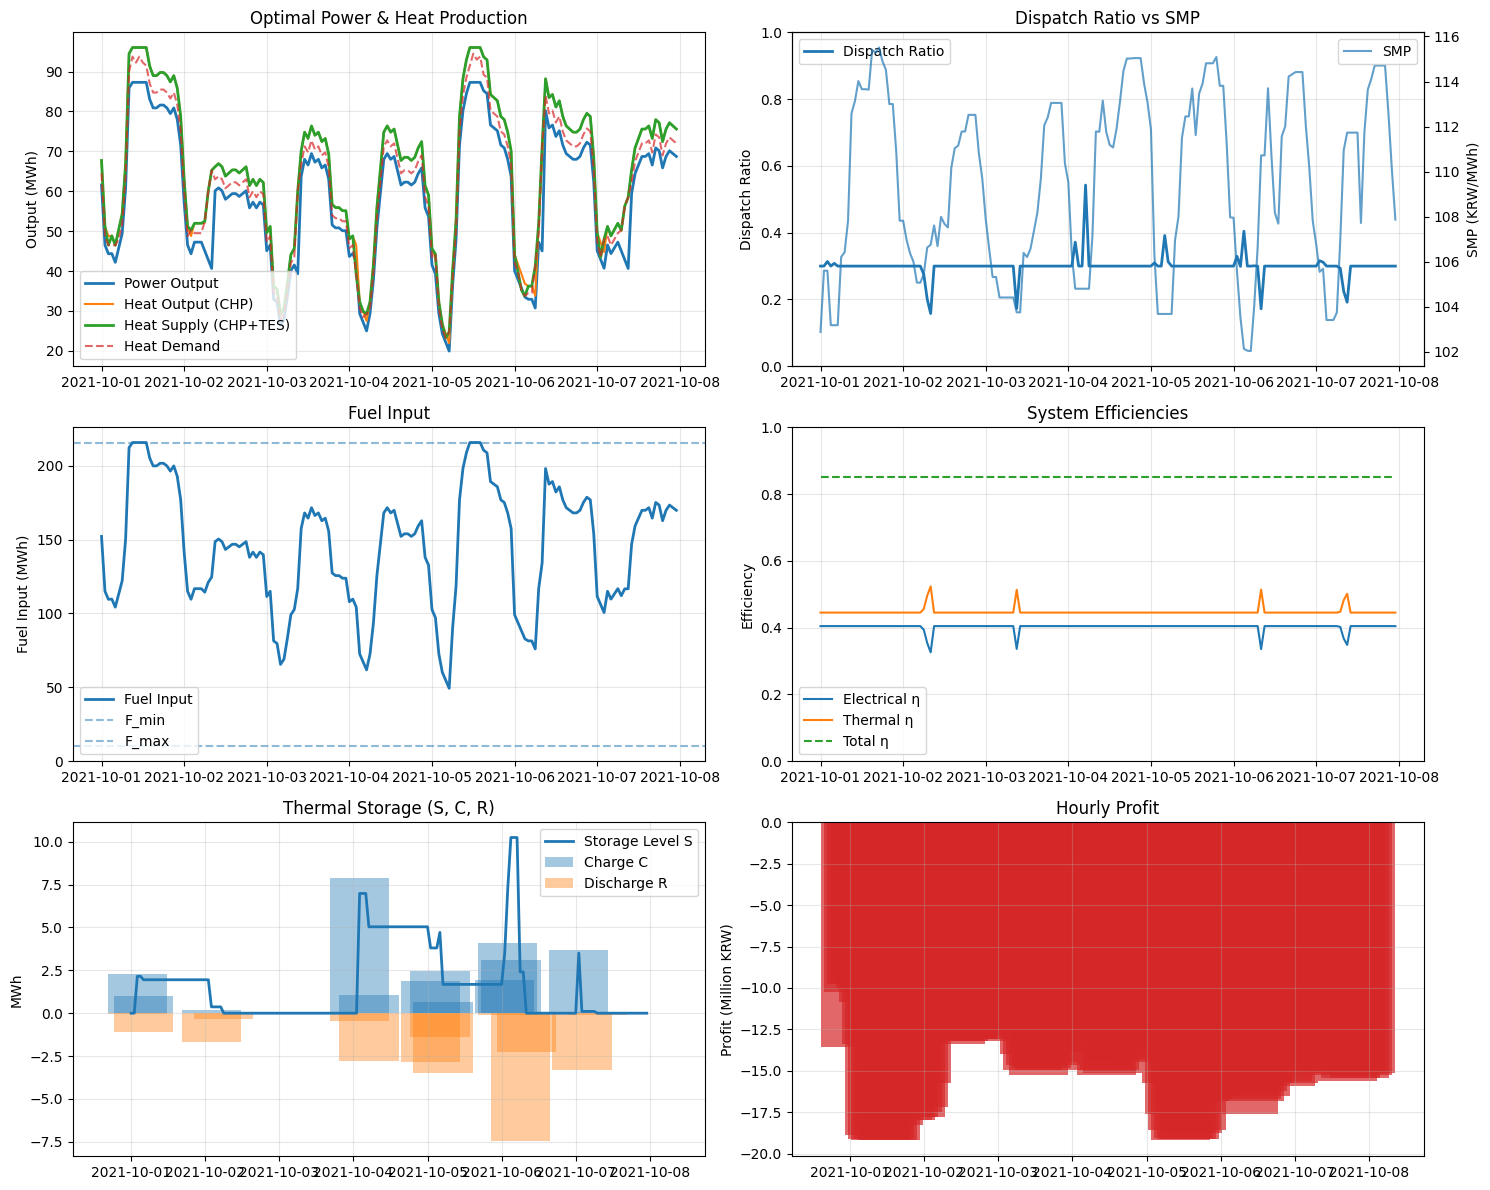


시각화 구간 최적화 성공률: 13.1%


In [27]:
results, optimizer = run_optimization(df_total)


In [22]:
optimizer